In [342]:
import numpy as np
import scipy as sp
import pandas as pd
import dask as da
import xarray as xy
import matplotlib.pyplot as plt
from matplotlib import cm  #colormap                                                                                                                  
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from time import time
import os.path
import cftime
from copy import deepcopy

from scipy.stats import ks_2samp as ksTest

from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list("", ["white","purple","purple"],N=10)


In [343]:
def getCal(fileName):
    temp = xy.open_dataset(fileName,decode_times=False)
    return temp.time.calendar

def addSeasonArray(y):
    return xy.DataArray([GroupbySeason(y,x) for x in np.arange(len(y.time))],name='season',dims=['time'])

def GroupbySeason(df, ind):
    month = int(str(df['time'].isel(time=ind).coords).split('-')[1])
    if month in [12,1,2]:
        return 'DJF'
    elif month in [3,4,5]:
        return 'MAM'
    elif month in [6,7,8]:
        return 'JJA'
    elif month in [9,10,11]:
        return 'SON'

def startslice(startYear,fileName):
    sm = 1
    if getCal(fileName) == '360_day':
        startslice = cftime.Datetime360Day(startYear, sm, 1,0,0,0,0,-1,1)
    else:
        startslice = str(startYear)+str(sm).zfill(2)+'01'

    return startslice

def endslice(endYear,fileName):
    if getCal(fileName) == '360_day':
        endslice = cftime.Datetime360Day(endYear, 12, 30,23,0,0,0,-1,360)
    else:
        endslice = str(endYear)+'1231'

    return endslice


In [344]:
def wetDayPercentile(y,q=85):
    #note hard-coded wet-day threshold of >0.1mm/d                                                                                                    
    return y.where(y>0.1).reduce(np.nanpercentile,dim='time',q=q)


In [345]:
 # arguments should be passed in:                                                                                                                  
#"label": plot title: "[analysis scenario rcm gcm location]"                                                                                      
label = "ksTestTail test[scenario rcm gcm location]"
#"obs": input file with observational data (single timeseries, one variable, one point)                                                           
obs = 'dataFiles/prec.obs.nc'
#"cur": same as obs, but for historical period of simulation                                                                                      
cur = 'dataFiles/prec.cur.nc'
#"fut": same as "cur", but for future period of simulation                                                                                        
fut = 'dataFiles/prec.fut.nc'
#"png": name of 'png' file to write the figure                                                                                                    
png = "testKStestTail.png"
#"var": name of data variable in input files                                                                                                      
var = "prec"
#"txt": name of file to write tab-delimited numerical metric results                                                                              
txt = "testKStestTail.csv"


In [346]:
def callKStest(col):
    try:
        toReturn = ksTest(pHistDF[col].dropna().squeeze().values,obsDF[col].dropna().squeeze().values)
        return (toReturn.statistic, toReturn.pvalue)
    except:
        return (np.NaN, np.NaN)

def toDF(data):
    dataWhere = data.loc[data['time.season']==season]
    dataWhere = dataWhere.where(dataWhere>pThreshOne.sel(season=season))
    dataStacked = dataWhere.stack(allpoints=['lat','lon']).squeeze()                                                                             
    return dataStacked.to_pandas()                                                                                         

obsData = xy.open_dataset(obs)
pThreshOne = obsData[var].groupby('time.season').apply(wetDayPercentile,q=85)

pHist = xy.open_dataset(cur)
pFuture = xy.open_dataset(fut)


In [347]:
if getCal(cur) == '360_day':
    grouperString = 'season'
    pHist.coords['season'] = addSeasonArray(pHist)
    pFuture.coords['season'] = addSeasonArray(pFuture)
else:
    grouperString = 'time.season'


In [348]:
t1 = time()
ksAll = pd.DataFrame()
for season in ['DJF','JJA']:
    pHistDF = toDF(pHist[var])
    pFutureDF = toDF(pFuture[var])
    obsDF = toDF(obsData[var])

    ksOut = pd.DataFrame((callKStest(col) for col in pHistDF),index=pHistDF.columns)
    ksAll[(season,'statistic')] = ksOut[0]
    ksAll[(season,'pvalue')] = ksOut[1]

ksAll = ksAll.transpose()
ksAll.index = pd.MultiIndex.from_tuples(ksAll.index)
ksAll.sort_index()
ksAll = ksAll.transpose()
t2=time()
print ('calculation took '+str(np.round(t2-t1,2))+'s')


calculation took 1.19s


/home/ngoldenson/miniconda2/envs/forPy3/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


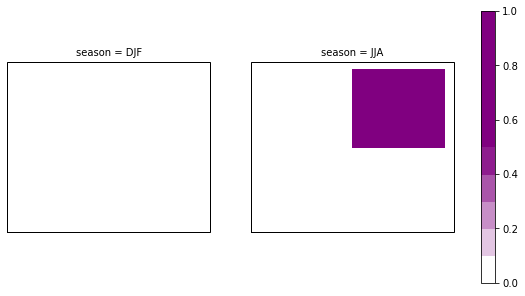

In [349]:
# for just a point or four, a map doesn't make much sense. 
# what would be a good accompanying visualization instead?
pValToPlot = ksAll.transpose().swaplevel(0,1).transpose()['pvalue'].to_xarray().to_array('season')
plotted = pValToPlot.plot.pcolormesh(transform=ccrs.PlateCarree(),col='season',col_wrap=2,
                                  subplot_kws={'projection':ccrs.LambertCylindrical(200)},
                                         figsize=[10,5],vmin=0,vmax=1,cmap=mycmap)
seasons = ['DJF','JJA']
for i, ax in enumerate(plotted.axes.flat):
    ax.coastlines(linewidth=1.4)

In [350]:
# write out the text file with the results
ksAll.to_csv(txt)

In [351]:
# demo, read it back in:
ksAllAgain = pd.read_csv(txt,index_col=[0,1],header=[0,1])
ksAllAgain

DJF                 JJA          
                  statistic    pvalue statistic    pvalue
lat       lon                                            
-33.08393 299.250  0.415158  0.000002  0.323544  0.000129
          300.375  0.346154  0.000021  0.234514  0.006874
-31.96244 299.250  0.248370  0.010386  0.256437  0.003600
          300.375  0.268485  0.000334  0.100394  0.589222

### instead, let's select just one lat/lon point first

In [404]:
# version for only one point, not set of lats/lons:
def toDF(data,overThresh=True):
    dataWhere = data.sel(time=data['time.season']==season)
    if overThresh:
        dataWhere = dataWhere.where(dataWhere>pThreshOne.sel(season=season))
    return dataWhere.to_pandas()    

def callKStest(df1,df2):
    try:
        toReturn = ksTest(df1.dropna().squeeze().values,df2.dropna().squeeze().values)
        return pd.Series([toReturn.statistic, toReturn.pvalue],index=['statistic','pValue'])
    except:
        return pd.Series([np.NaN, np.NaN],index=['statistic','pValue'])


In [405]:
obsData = xy.open_dataset(obs)
pThreshOne = obsData[var].groupby('time.season').apply(wetDayPercentile,q=85)

pHist = xy.open_dataset(cur)
pFuture = xy.open_dataset(fut)

pThreshOne = pThreshOne.isel(lat=0,lon=0)

In [406]:
t1 = time()
ksOut = pd.DataFrame()
ksOutFut = pd.DataFrame()
for i, season in enumerate(['DJF','MAM','JJA','SON']):
    obsDF = toDF(obsData[var].isel(lat=0,lon=0))
    histDF = toDF(pHist[var].isel(lat=0,lon=0))
    futureDF = toDF(pFuture[var].isel(lat=0,lon=0))
    
    ksOut[season] = callKStest(histDF,obsDF)
    ksOutFut[season] = callKStest(histDF,futureDF)
    
t2=time()
print ('calculation took '+str(np.round(t2-t1,2))+'s')

calculation took 2.17s


In [396]:
ksOut.to_csv(txt)

In [385]:
#test read back in:
ksOutAndBack = pd.read_csv(txt,index_col=0)
ksOutAndBack

,DJF,MAM,JJA,SON
statistic,0.415158,0.295273,0.323544,0.117272
pValue,0.000002,0.000052,0.000129,0.355096


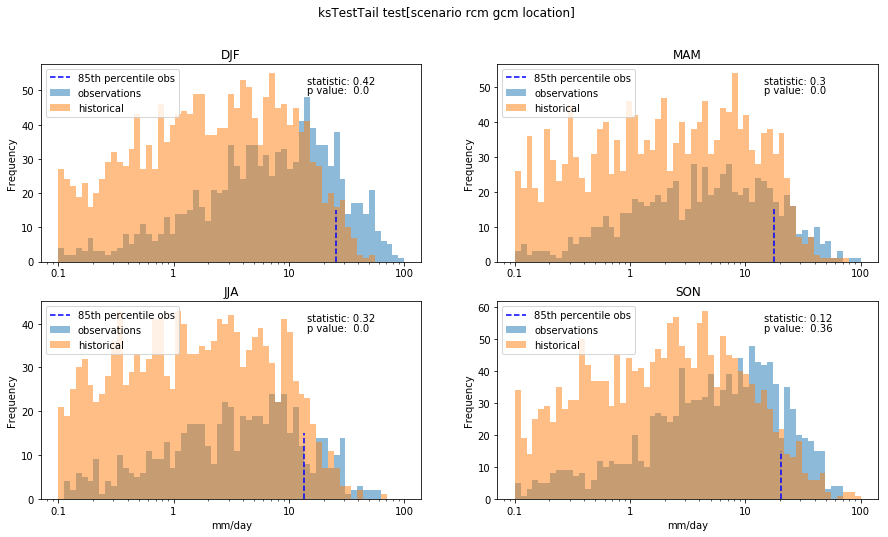

In [419]:
binsToUse = np.logspace(-1,2,60)
plt.figure(figsize=[15,8])
for i, season in enumerate(['DJF','MAM','JJA','SON']):
    obsDF = toDF(obsData[var].isel(lat=0,lon=0),overThresh=False)
    histDF = toDF(pHist[var].isel(lat=0,lon=0),overThresh=False)
    futureDF = toDF(pFuture[var].isel(lat=0,lon=0),overThresh=False)
    
    ax = plt.subplot(2,2,i+1)
    obsDF.plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5,label='observations') 
    histDF.plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5,label='historical') 
    #futureDF.plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5,label='future') 
    ax.plot(np.zeros(10)+pThreshOne.sel(season=season).data,np.linspace(0,15,10),linestyle='--',color='b',label='85th percentile obs')    

    ax.set(xscale='log')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
    if i>1:
        try:
            units = obsData[var].attrs['units']
            plt.xlabel(units)
        except:
            plt.xlabel('default units in file')
    plt.title(season)
    plt.legend(loc='upper left')
    ax.annotate('statistic: '+str(np.round(ksOut[season]['statistic'],2)),xy=(0.7,0.9),
                xycoords='axes fraction')
    ax.annotate('p value:  '+str(np.round(ksOut[season]['pValue'],2)),xy=(0.7,0.85),
                xycoords='axes fraction')

plt.suptitle(label)
plt.savefig(png)

#### Too busy with future on the same plots. Separately look at whether historical and future simulations could be said to be drawn from the same larger distribution.

Text(0.5, 0.98, 'ksTestTail test[scenario rcm gcm location]')

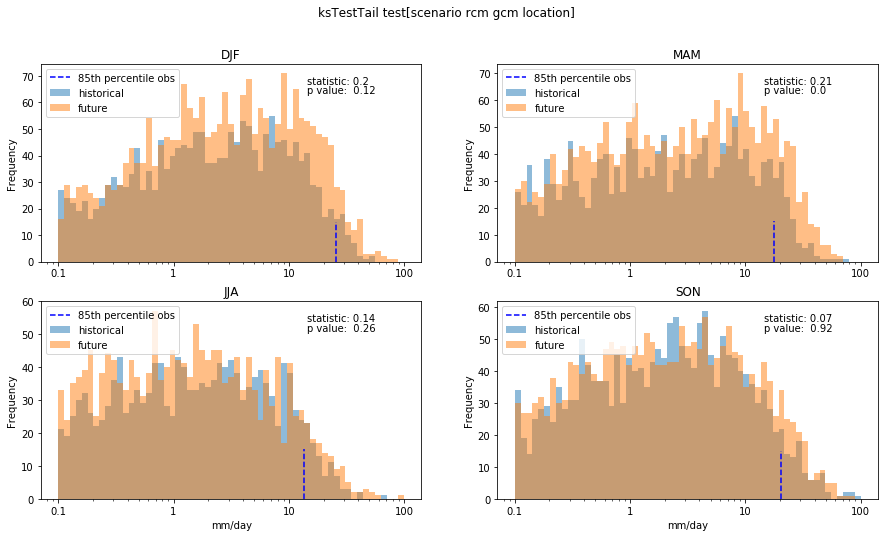

In [407]:
binsToUse = np.logspace(-1,2,60)
plt.figure(figsize=[15,8])
for i, season in enumerate(['DJF','MAM','JJA','SON']):
    #obsDF = toDF(obsData[var].isel(lat=0,lon=0),overThresh=False)
    histDF = toDF(pHist[var].isel(lat=0,lon=0),overThresh=False)
    futureDF = toDF(pFuture[var].isel(lat=0,lon=0),overThresh=False)
    
    ax = plt.subplot(2,2,i+1)
    #obsDF.plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5,label='observations') 
    histDF.plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5,label='historical') 
    futureDF.plot.hist(ax=ax,bins=binsToUse,stacked=False,alpha=0.5,label='future') 
    ax.plot(np.zeros(10)+pThreshDF[season],np.linspace(0,15,10),linestyle='--',color='b',label='85th percentile obs')    

    ax.set(xscale='log')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
    if i>1:
        try:
            units = obsData[var].attrs['units']
            plt.xlabel(units)
        except:
            plt.xlabel('default units in file')
    plt.title(season)
    plt.legend(loc='upper left')
    ax.annotate('statistic: '+str(np.round(ksOutFut[season]['statistic'],2)),xy=(0.7,0.9),
                xycoords='axes fraction')
    ax.annotate('p value:  '+str(np.round(ksOutFut[season]['pValue'],2)),xy=(0.7,0.85),
                xycoords='axes fraction')

plt.suptitle(label)
